Instalamos algunos paquetes


In [1]:
pip install nltk  

     |████████████████████████████████| 1.5 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 720 kB 18.9 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 6.3 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install Seaborn


Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install wordcloud

     |████████████████████████████████| 366 kB 4.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [23]:
import glob
import sys, csv
import nltk
nltk.download('stopwords')
from nltk.tokenize import wordpunct_tokenize
from scipy.special import psi
from wordcloud import WordCloud
import xml.etree.ElementTree as ET
import numpy as n
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pandas as pd

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Cargamos los documentos 


In [16]:
filenames = glob.glob('AbstractsClass/*.xml')


Definimos algunas funciones para procesar los documentos 


In [17]:
#La siguiente funcion devuelve el abstract de un archivo que se le introduzca.
def getabstract(filename):
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~123456789'''
    # print "getting file " + filename
    tree = ET.parse(filename, parser= ET.XMLParser(encoding = 'iso-8859-5'))
    root = tree.getroot()
    doc = " "
    for i in root[0]:
        if i.tag == 'AbstractNarration' and i.text is not None:
            doc = i.text
            doc = doc.replace('<br/>', ' ')
            doc = doc.replace('т\x80\x99',' ')
            doc = doc.replace('т\x80\x94', ' ')
            doc = doc.replace('т\x80\x9c', ' ')
            doc = doc.replace('т\x80\x9d', ' ')
            no_punt = ""
            for char in doc:
                if char not in punctuations:
                    no_punt = no_punt + char
            doc = no_punt
            doc = doc.lower()
            doc = ' '.join([word for word in doc.split() if word not in stopwords.words('english')])
    # print doc
    return doc
#la siguiente funci'on devuelve el título de un artícilo dado


def gettitle(filename):
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~123456789'''
    tree = ET.parse(filename, parser=ET.XMLParser(encoding='iso-8859-5'))
    root = tree.getroot()
    doc = " "
    for i in root[0]:
        if i.tag == 'AwardTitle' and i.text is not None:
            doc = i.text
            doc = doc.lower()
            doc = ' '.join([word for word in doc.split() if word not in stopwords.words('english')])
            no_punt = ""
            for char in doc:
                if char not in punctuations:
                    no_punt = no_punt + char
            doc = no_punt
    # print doc
    return doc

#La siguiente funcion  devuelve una lista con todos los abstracts no vacios
def getalldocs():
    files = filenames
    docs = []
    for file in files:
        doc = getabstract(file)
        # print doc
        if doc != " ":
            docs.append(doc)
    # print docs
    return docs


#La siguiente funci'on devuelve todos los titulos del premio de un articulo dado

def getalltitles():
    files = filenames
    titles = []
    for file in files:
        tit = gettitle(file)
        doc = getabstract(file)
        # print doc
        if doc != " ":
            titles.append(tit)
    # print docs
    return titles


Ahora procesamos los datos y hacemos un gord cloud

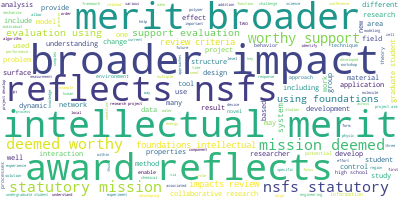

In [28]:
#Pegamos las dos listas
listTitle_Abstract = {'titles': getalltitles(), 'abstract': getalldocs()}
#Convertimos la lista en un data frame
abstTitleDF = pd.DataFrame(listTitle_Abstract, columns=['titles', 'abstract'])
# Pegamos todos las palabras procesadas.
long_string = ','.join(list(abstTitleDF['titles'].values))
long_string += ','.join(list(abstTitleDF['abstract'].values))
wordcloud = WordCloud(background_color="white", max_words=10000, contour_width=3, contour_color='steelblue')
# Generamos un word cloud
wordcloud.generate(long_string)
# Visualizaci'on del word cloud
wordcloud.to_image()


Ahora contamos las palabras mas repetidas en los documentos

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


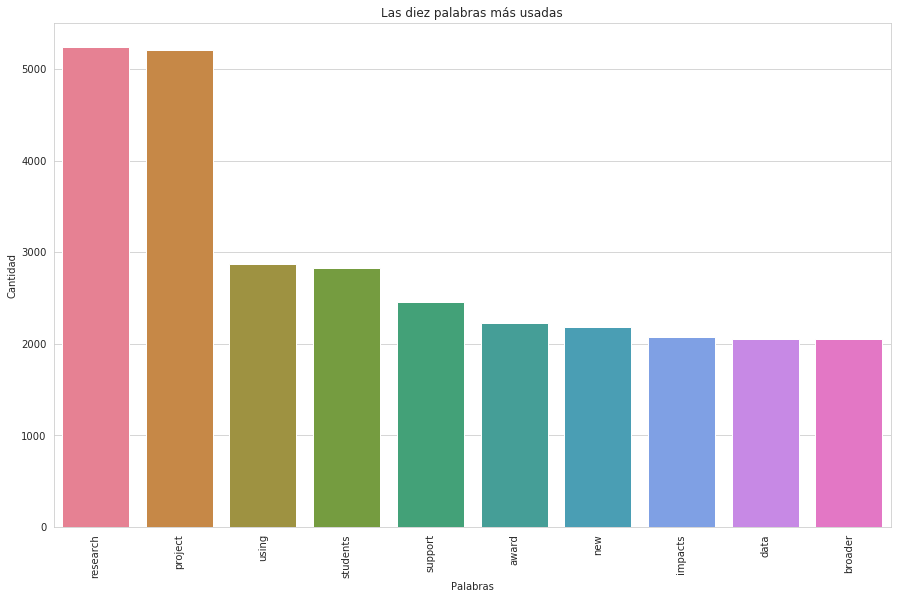

In [29]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize=(15, 15 / 1.6180))
    plt.subplot(title='Las diez palabras más usadas')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('Palabras')
    plt.ylabel('Cantidad')
    plt.show()


# Inicializamos el count vectorizer cpn las English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform de los documentos procesados
count_data = count_vectorizer.fit_transform(long_string.split())
# Visualisamos las 10 palabras mas usadas
plot_10_most_common_words(count_data, count_vectorizer)

Ahora aplicamos Latent Diricleth Allocation a los documentos, para clasificar los documentos por temas 

In [30]:
# La siguiente funci'on  devuelve los temas datos por lda y sus palabras
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))


# Definimos el numero de temas y palabras por tema
number_topics = 8
number_words = 10
# Creamos y ajustamos el LDA
lda = LDA(n_components=number_topics, n_jobs=-1, learning_method= 'online')
lda.fit(count_data)
# Imorimimos los temas y las palabras
print("Temas encontrados  via LDA:")
print_topics(lda, count_vectorizer, number_words)



Topics found via LDA:

Topic #0:
evaluation deemed understanding program applications models different surface structures student

Topic #1:
new impacts materials intellectual nsfs merit mission systems develop education

Topic #2:
support criteria study stem undergraduate quantum engineering water technology aims

Topic #3:
project research students award data reflects work design model knowledge

Topic #4:
broader worthy science development used university theory important chemistry energy

Topic #5:
foundations statutory provide use high methods training groups community fundamental

Topic #6:
using learning properties information climate field fields interactions public physics

Topic #7:
review including graduate chemical impact activities school tools based improve


Finalmente imprimimos los documentos con su tema asignado por el algoritmo

In [ ]:
doc_topic = lda.transform(count_data)
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

doc: 0 topic: 0

doc: 1 topic: 0

doc: 2 topic: 0

doc: 3 topic: 6

doc: 4 topic: 0

doc: 5 topic: 2

doc: 6 topic: 4

doc: 7 topic: 7

doc: 8 topic: 6

doc: 9 topic: 6

doc: 10 topic: 6

doc: 11 topic: 6

doc: 12 topic: 5

doc: 13 topic: 5

doc: 14 topic: 5

doc: 15 topic: 0

doc: 16 topic: 1

doc: 17 topic: 2

doc: 18 topic: 2

doc: 19 topic: 4

doc: 20 topic: 2

doc: 21 topic: 2

doc: 22 topic: 3

doc: 23 topic: 1

doc: 24 topic: 0

doc: 25 topic: 2

doc: 26 topic: 7

doc: 27 topic: 7

doc: 28 topic: 5

doc: 29 topic: 5

doc: 30 topic: 2

doc: 31 topic: 5

doc: 32 topic: 1

doc: 33 topic: 3

doc: 34 topic: 6

doc: 35 topic: 6

doc: 36 topic: 1

doc: 37 topic: 7

doc: 38 topic: 3

doc: 39 topic: 7

doc: 40 topic: 4

doc: 41 topic: 5

doc: 42 topic: 1

doc: 43 topic: 1

doc: 44 topic: 0

doc: 45 topic: 6

doc: 46 topic: 4

doc: 47 topic: 2

doc: 48 topic: 1

doc: 49 topic: 7

doc: 50 topic: 5

doc: 51 topic: 3

doc: 52 topic: 5

doc: 53 topic: 4

doc: 54 topic: 4

doc: 55 topic: 0

do